*Summary*
*  Load intamt data
*  Load Optical system sensitivity matrix
*  Perform standard SVD
*  Perform weighted SVD with weight 1
*  Compute sensitivity matrix using Negro84
*  Perform weighted SVD with weight from Negro84

In [1]:
#initialize OTT simulator
#from m4.mini_OTT import timehistory as th

from m4.configuration import start_onlydata
import os


#laod liraries and data
from arte.utils.zernike_projection_on_subaperture import ZernikeProjectionOnSubaperture
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

start_onlydata.create_conf_paths(os.environ['PYOTTCONF'])


IMfile="/mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/InteractionMatrix.fits"
cmfile="/mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/CMat.fits"
ampfile="/mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/CommandAmplitude.fits"
hdul = fits.open(IMfile)
hdul.info()
IMat_loaded=hdul[0].data.copy()
print("scaled 1e9 loaded intmat")
with np.printoptions(precision=3, suppress=True):
    print(IMat_loaded*1e9)
hdul.close()

hdul = fits.open(cmfile)
hdul.info()
cmat=hdul[0].data.copy()
print(cmat)
hdul.close()
IMat = IMat_loaded @ np.linalg.pinv(cmat)
#IMat = IMat_loaded.copy() #test purpose
print("scaled 1e9 intmat projected to orthognormal commands")
with np.printoptions(precision=3, suppress=True):
    print(IMat*1e9)


hdul = fits.open(ampfile)
hdul.info()
amp=hdul[0].data.copy()
print(amp)
hdul.close()


Using the Python console for data analysis.
Base data path is: /mnt/backup/Archeopterix_20230517/Data/

           |X|_____ _____|X|
           |X|           |X|
           |X|_____--___<|X|
           |X|    |\  /| |X|
     __    |X|    |_\/_| |X|
    |  |   |X|    | /\ | |X|
    |  |   |X|    |/  \| |X|
 ___|__|___|X|____ ---- _|X|_____
Filename: /mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/InteractionMatrix.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (5, 5)   float64   
scaled 1e9 loaded intmat
[[ 1440.882   967.535  2498.833   -68.245 -5213.151]
 [ 2867.633  -226.71     90.848  5260.101   183.622]
 [-4173.39    -22.824    -1.062     1.796     2.687]
 [  -16.417  -422.737    -0.386    -8.178    -8.092]
 [   -3.616    -5.007   428.077    -5.885    -5.645]]
Filename: /mnt/backup/Archeopterix_20230517/Data/M4Data/OPTData/AlignmentCalibration/20231027_131458/CMat.fits
No.    Na

In [2]:
#Simulate M4 case sub-pupil
pupilRadiusInMeter = 0.7
subapsRadiusInMeter = 0.3
subapOffAxisRadiusInMeter = 0.15
subapOffAxisAzimuthInDegrees = 0
Zproj = ZernikeProjectionOnSubaperture(pupilRadiusInMeter,subapsRadiusInMeter,subapOffAxisRadiusInMeter,subapOffAxisAzimuthInDegrees)
S = Zproj.get_projection_matrix()
print("Negro84 sensitivity matrix small pupil coeffs (rows) and large pupil coeffs (columns)")
with np.printoptions(precision=3, suppress=True):
    print(S)
S_inv = np.linalg.inv(S)
print("Negro84 sensitivity matrix large pupil coeffs (rows) and small pupil coeffs (columns)")
with np.printoptions(precision=1, suppress=True):
    print(S_inv)

Negro84 sensitivity matrix small pupil coeffs (rows) and large pupil coeffs (columns)
[[ 0.429  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.429  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.318  0.     0.184  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.225  0.     0.184  0.     0.     0.     0.     0.     0.   ]
 [ 0.225 -0.     0.     0.     0.184  0.     0.     0.     0.     0.   ]
 [ 0.    -0.906  0.     0.136 -0.     0.079  0.     0.     0.     0.   ]
 [-0.739  0.     0.193  0.     0.136  0.     0.079  0.     0.     0.   ]
 [ 0.     0.083  0.     0.136  0.     0.     0.     0.079  0.     0.   ]
 [ 0.083 -0.     0.    -0.     0.136  0.     0.     0.     0.079  0.   ]
 [-0.817 -0.    -0.45   0.     0.092  0.     0.107  0.     0.     0.034]]
Negro84 sensitivity matrix large pupil coeffs (rows) and small pupil coeffs (columns)
[[   2.3   -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0. ]
 [  -0.     2.3   -0.   

weight matrix
[[1372.8    0.  -512.2    0.   466.9]
 [   0.  1017.1    0.   404.1    0. ]
 [-512.2    0.   207.5    0.  -169.4]
 [   0.   404.1    0.   161.4    0. ]
 [ 466.9    0.  -169.4    0.   161.4]]


Text(0.5, 1.0, 'eigenvalues change ratio')

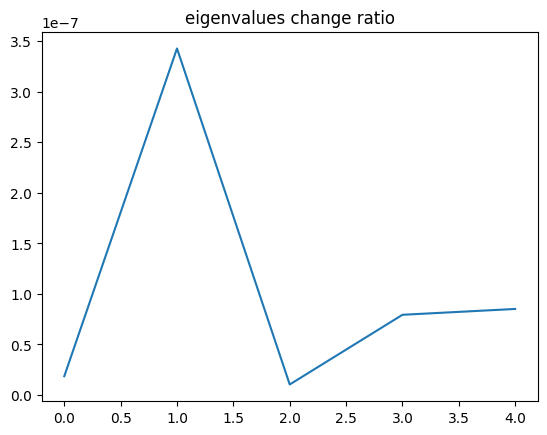

In [3]:
#rec mat standard way
RMat = np.linalg.pinv(IMat)
selection = [0,1,2,5,6]
SMat = (S_inv[:,selection].T)[:,selection].T
W = SMat.T @ SMat
Uw, Dw, Vhw = np.linalg.svd(W, full_matrices=True)
#Dw[1]=1e6
#W = np.diag(Dw*1e6)   #only for test purpose
print("weight matrix")
with np.printoptions(precision=1, suppress=True):
    print(W)
#new rec mat to test
RMat2 = np.linalg.inv(IMat.T @ W @ IMat) @ IMat.T @ W

U, D, Vh = np.linalg.svd(RMat, full_matrices=True)
U2, D2, Vh2 = np.linalg.svd(RMat2, full_matrices=True)
Ui, Di, Vhi = np.linalg.svd(IMat, full_matrices=True)
Uw, Dw, Vhw = np.linalg.svd(W, full_matrices=True)
plt.plot(np.abs((D2-D)/D))
plt.title("eigenvalues change ratio")


Marginal changes in the singular values of RMat. Why? The hypothesys is that SINCE WE HAVE ONLY Nmeas==NDOF, there is no room for weighting. Remind that the measures are "perfect" by themselves but each component of the measure has a dirfferent noise from the others.
For verifying that, we add more Commands and Measures to the intmat.

Reding Frame_0000.fits
Reding Frame_0001.fits
Reding Frame_0002.fits
Reding Frame_0003.fits
Reding Frame_0004.fits
Reding Frame_0005.fits
Reding Frame_0006.fits
Reding Frame_0007.fits
Reding Frame_0008.fits
Reding Frame_0009.fits
Reding Frame_0010.fits
Reding Frame_0011.fits
Reding Frame_0012.fits
Reding Frame_0013.fits
Reding Frame_0014.fits
Reding Frame_0015.fits
Reding Frame_0016.fits
Reding Frame_0017.fits
Reding Frame_0018.fits
Reding Frame_0019.fits
[[ 6.01188349e-08 -1.02475591e-06  5.50050363e-07 -2.47210436e-07
   8.11135744e-07 -4.77828679e-07  2.51107786e-07  2.59576249e-07
  -1.86690269e-06  2.44522946e-06  3.97898420e-08 -1.02430522e-06
   6.54464474e-07 -1.62528714e-07  8.17543657e-07 -3.58248284e-07
   1.21923839e-07  2.03096110e-07 -1.86421638e-06  2.40050830e-06]
 [ 9.78620264e-07 -1.34438050e-06  2.51629557e-08 -5.94630936e-07
  -4.26812005e-07 -5.38094141e-07  1.83909381e-06 -2.52866101e-06
  -2.79117574e-07 -4.37033432e-07  1.09259709e-06 -1.28697432e-06
   4.843725

Text(0.5, 1.0, 'eigenvalues change ratio')

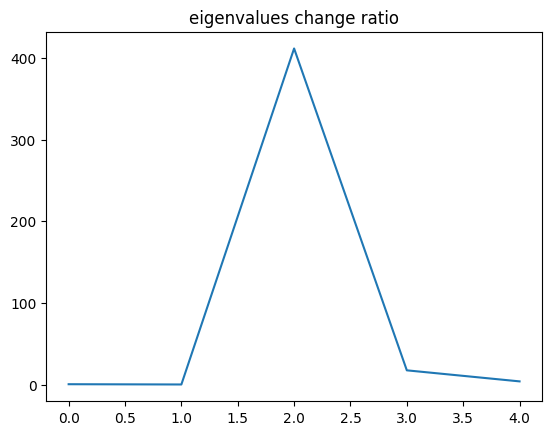

In [4]:

#load libraries
from m4.utils.optical_calibration import OpticalCalibration
from m4.ground import read_data
import numpy as np
from m4.ground import zernike as zern
from m4.ground import geo as geo




oo = OpticalCalibration.loadCalibrationObjectFromFits('20231027_131458')
meas = oo.getCube()
cmd  = oo.getCommandMatrix()
fullCmd = oo.getFullCommandMatrix()
fullMeas = oo.getFullCube()

CMat = fullCmd.copy()
IMat = oo.getFullLocalInteractionMatrix()  #@ np.linalg.pinv(CMat)
 
print(IMat)

#rec mat standard way
RMat = CMat @ np.linalg.pinv(IMat)
selection = [0,1,2,5,6]
SMat = (S_inv[:,selection].T)[:,selection].T
W = SMat.T @ SMat
Uw, Dw, Vhw = np.linalg.svd(W, full_matrices=True)
#Dw[1]=1e6
#W = np.diag(Dw)   #only for test purpose
print("weight matrix")
with np.printoptions(precision=1, suppress=True):
    print(W)
#new rec mat to test
RMat2 = CMat @ np.linalg.inv(IMat.T @ W @ IMat) @ IMat.T @ W

U, D, Vh = np.linalg.svd(RMat, full_matrices=True)
U2, D2, Vh2 = np.linalg.svd(RMat2, full_matrices=True)
Ui, Di, Vhi = np.linalg.svd(IMat, full_matrices=True)
Uw, Dw, Vhw = np.linalg.svd(W, full_matrices=True)
plt.plot(np.abs((D2-D)/D))
plt.title("eigenvalues change ratio")



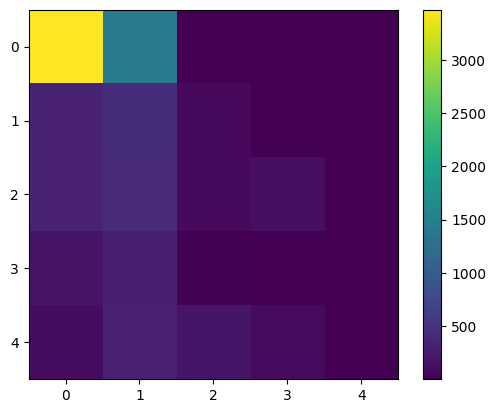

In [5]:
plt.imshow(np.abs ((RMat-RMat2)/RMat))
plt.colorbar()